<a href="https://colab.research.google.com/github/PTson2207/Engineer-Selection/blob/main/Pipeline_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# About Data

In [2]:
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data", 
                 header=None, names=['StaAcc', 'DuMon', 'CredHis', 'Purpose', 'CredAmt', 'SavAcc', \
                                     'PreEmpl', 'InsRt', 'PerSta', 'OthDebtor', 'PreRe', 'Property', \
                                     'Age', 'IntPla', 'Housing', 'ExstCredit', 'Job', 'NoMain', 'Phone', 'ForWorker', "Response"], 
                 index_col=None, sep=" ")
df.head()

,StaAcc,DuMon,CredHis,Purpose,CredAmt,SavAcc,PreEmpl,InsRt,PerSta,OthDebtor,PreRe,Property,Age,IntPla,Housing,ExstCredit,Job,NoMain,Phone,ForWorker,Response
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StaAcc      1000 non-null   object
 1   DuMon       1000 non-null   int64 
 2   CredHis     1000 non-null   object
 3   Purpose     1000 non-null   object
 4   CredAmt     1000 non-null   int64 
 5   SavAcc      1000 non-null   object
 6   PreEmpl     1000 non-null   object
 7   InsRt       1000 non-null   int64 
 8   PerSta      1000 non-null   object
 9   OthDebtor   1000 non-null   object
 10  PreRe       1000 non-null   int64 
 11  Property    1000 non-null   object
 12  Age         1000 non-null   int64 
 13  IntPla      1000 non-null   object
 14  Housing     1000 non-null   object
 15  ExstCredit  1000 non-null   int64 
 16  Job         1000 non-null   object
 17  NoMain      1000 non-null   int64 
 18  Phone       1000 non-null   object
 19  ForWorker   1000 non-null   object
 20  Response 

In [4]:
df.describe()

,DuMon,CredAmt,InsRt,PreRe,Age,ExstCredit,NoMain,Response
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,1.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


    Kết quả thống kê mô tả sơ bộ trên các biến numeric cho thấy các biến khác biệt nhau về đơn vị lớn. 
    Trung bình thấp nhất là 1.155 và cao nhất lên tới 3271.258. Như vậy khả năng cao chúng ta sẽ cần phải chuẩn hoá các biến để 
    loại bỏ sự khác biệt về đơn vị trước khi xây dựng mô hình.

## Phân phối của các biến

### Biến Liên Tục

number of numeric field:  8


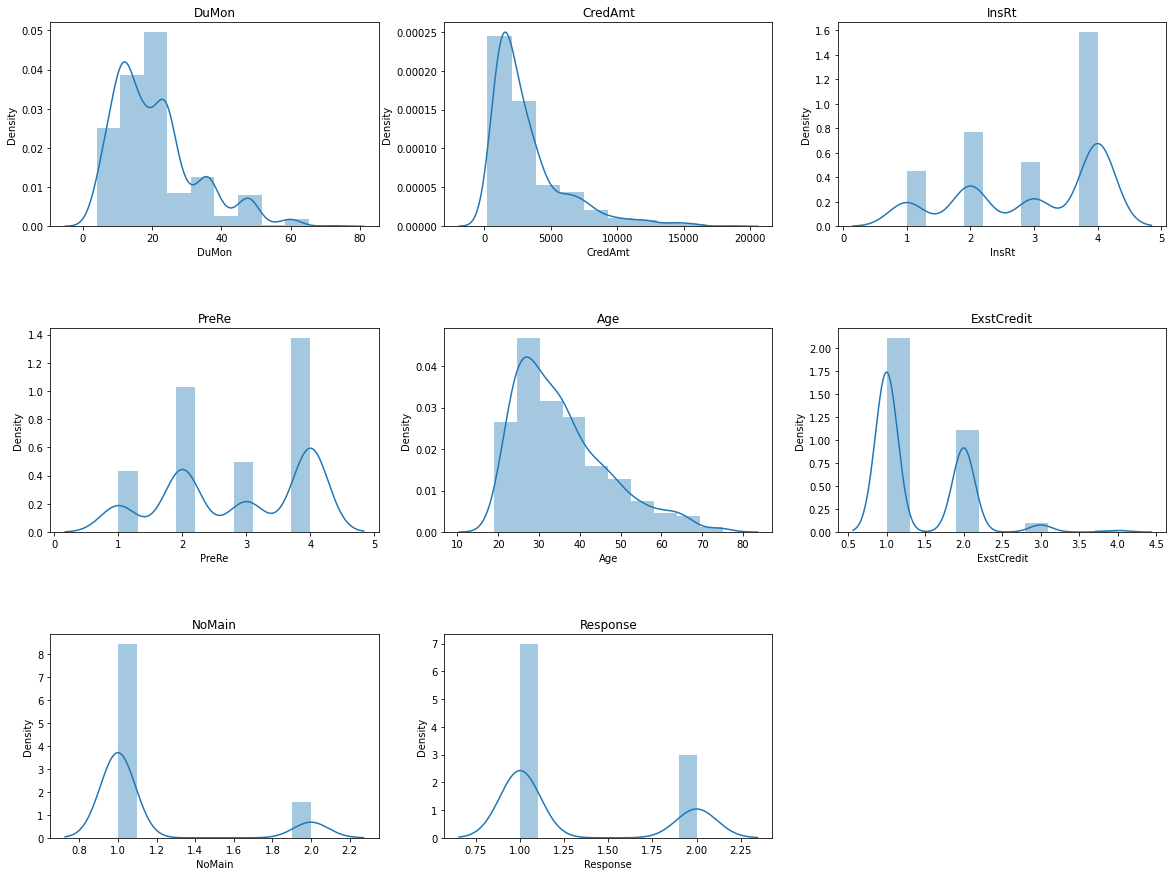

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

numeric_cols = df.select_dtypes(include=['float','int']).columns

def _plot_numeric_classes(df, col, bins=10, hist=True, kde=True):
    sns.distplot(df[col],
                 bins = bins,
                 hist = hist,
                 kde = kde)

def _distribution_numeric(df, numeric_cols, row=3, col=3, figsize=(20, 15), bins = 10):
    '''
    numeric_cols: list các tên cột
    row: số lượng dòng trong lưới đồ thị
    col: số lượng cột trong lưới đồ thị
    figsize: kích thước biểu đồ
    bins: số lượng bins phân chia trong biểu đồ distribution
    '''
    print('number of numeric field: ', len(numeric_cols))
    assert row*(col-1) < len(numeric_cols)
    plt.figure(figsize = figsize)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
    for i in range(1, len(numeric_cols)+1, 1):
      try:
        plt.subplot(row, col, i)
        _plot_numeric_classes(df, numeric_cols[i-1], bins = bins)
        plt.title(numeric_cols[i-1])
      except:
        print('Error {}'.format(numeric_cols[i-1]))
        break

_distribution_numeric(df, numeric_cols)

    Ta thấy môt số biến thực chất là biến thứ bậc, khi các giá trị chỉ rơi vào một tập giá trị nhất định. Chẳng hạn như
    biến PreRe chỉ rơi vào các giá trị [1, 2, 3, 4]. Khi nhìn vào biểu đồ phân phối của các biến ta có thể nhận định được
    đâu là miền các biến có độ tập trung cao và thấp?
    --> Xác định được các biến có phù hợp với thực tế hay không?

### Biến Phân Loại

Số lượng biến phân loại: 13


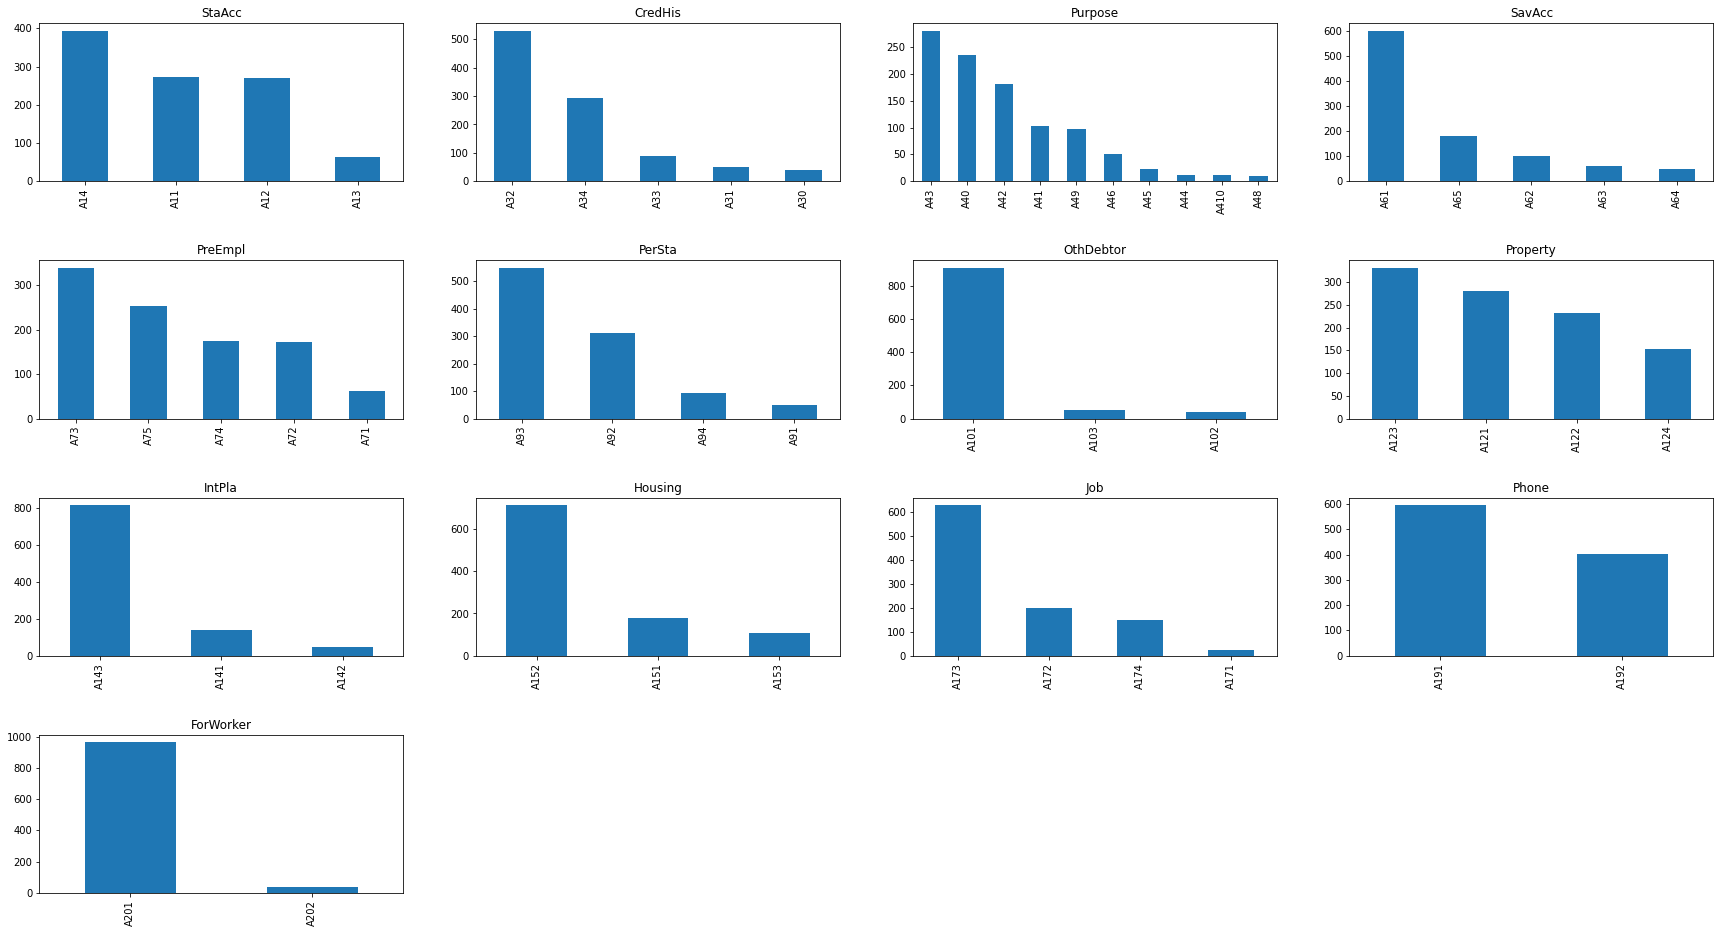

In [6]:
category_cols = df.select_dtypes('O').columns
def _plot_bar_classes(df, cols):
    df[cols].value_counts().plot.bar()

def _distribution_category(df, category_cols, row=1, col=2, figsize=(20, 5)):
    print('Số lượng biến phân loại:', len(category_cols))
    plt.figure(figsize=figsize)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
    for i in range(1, len(category_cols)+1, 1):
        try:
            plt.subplot(row, col, i)
            _plot_bar_classes(df, category_cols[i-1])
            plt.title(category_cols[i-1])
        except:
            break

_distribution_category(df, category_cols, row=4, col=4, figsize=(30, 16))

    Có nhiều nhãn phân loại có số lượng quan sát rất ít. heo kinh nghiệm thì các nhãn thiểu số lại có thể là đặc trưng riêng của một nhãn đầu ra. 
    Vì thế chúng ta có thể khảo sát thêm tỷ lệ giữa GOOD/BAD cách biệt như thế nào ở những nhãn này. Kết quả đánh giá chúng có thể giúp ta đưa ra một
    số kết luận hữu ích đối với phân loại nhã 

# Chia Train & Test

In [7]:
# Chia train/test theo tỷ lệ 80:20.
df_train, df_test = train_test_split(df, test_size=0.2, stratify = df['Response'])
X_train = df_train.copy()
y_train = X_train.pop("Response")

X_test = df_test.copy()
y_test = X_test.pop("Response")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 20) (800,)
(200, 20) (200,)


# Pipeline Processing Data

In [8]:
cat_names = list(X_train.select_dtypes(include=['O']).columns)
num_names = list(X_train.select_dtypes(exclude=['O']).columns)

## Pipeline xử lí cho biến phân loại

In [9]:
cat_pl = Pipeline(
    steps=[
           ('imputer', SimpleImputer(strategy='most_frequent')), # Xử lí mising data bằng cách thay thế most frequency
           ('onehot', OneHotEncoder()), # Encode các biến trong columns
    ]
)

## Pipeline xử lí cho biến liên tục

In [10]:
num_pl = Pipeline(
    steps=[
           ('imputer', KNNImputer(n_neighbors=7)),
           ('scale', MinMaxScaler()), # Xử lí missing data 
    ]
)

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
                  ('num', num_pl, num_names), #áp dụng pipeline cho biến liên tục
                  ('cat', cat_pl, cat_names), #áp dụng pipeline cho biến phân loại
    ]
)

# PIpeline Hoàn chỉnh

In [12]:
completed_pl = Pipeline(
    steps=[
           ('preprocessor', preprocessor),
           ('classifier', RandomForestClassifier()),
    ]
)

In [13]:
# Training 
completed_pl.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   KNNImputer(add_indicator=False,
                                                                              copy=True,
                                                                              metric='nan_euclidean',
                                                                              missing_values=nan,
                                                                              n_neighbors=7,
                                                                         

In [14]:
#accuracy
y_train_pred = completed_pl.predict(X_train)
print("Accuracy on train:", accuracy_score(list(y_train),list(y_train_pred)))

Accuracy on train: 1.0


In [15]:
y_pred = completed_pl.predict(X_test)
print("Accuracy on test:", accuracy_score(list(y_test), list(y_pred)))

Accuracy on test: 0.73


    Mô hình có độ chính xác trên tập train là 100% và trên tập test là 76% cho thất có hiện tượng overfitting.
    Để khắc phục overfitting, ta có thể thực hiện cross validation

# Cross Validation

In [16]:
from sklearn.metrics import fbeta_score, make_scorer

def fbeta(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=np.sqrt(5))


    Dữ liệu bị mất cần bằng thì dùng F1-score để đánh giá mô hình(xem chi tiết ở vở ghi chú)

In [17]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_split: số lần chia dữ liệu
# n_repeat là số lần lặp lại quá trình cross_validation
# như vậy có tổng cộng n_splits x n_repeat = 30 lượt đánh giá dữ liệu
# Xác định metrics cho mô hình
metric = make_scorer(fbeta)
# Đánh giá mô hình
scores = cross_val_score(completed_pl, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)
print('Mean Fbeta: {:.03f} {:.03f}'.format(np.mean(scores), np.std(scores)))

Mean Fbeta: 0.900 0.025


# Đánh giá nhiều mô hình

In [18]:
models =  [GaussianNB(), LogisticRegression(), KNeighborsClassifier(), MLPClassifier(), RandomForestClassifier()]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

all_scores = []
for model in models:
    completed_pl = Pipeline(
        steps=[
               ("preprocessor", preprocessor),
               ("classifier", model),
        ]
    )
    scores = cross_val_score(completed_pl, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)
    all_scores.append(scores)

Text(0.5, 1.0, 'Scores Metrics')

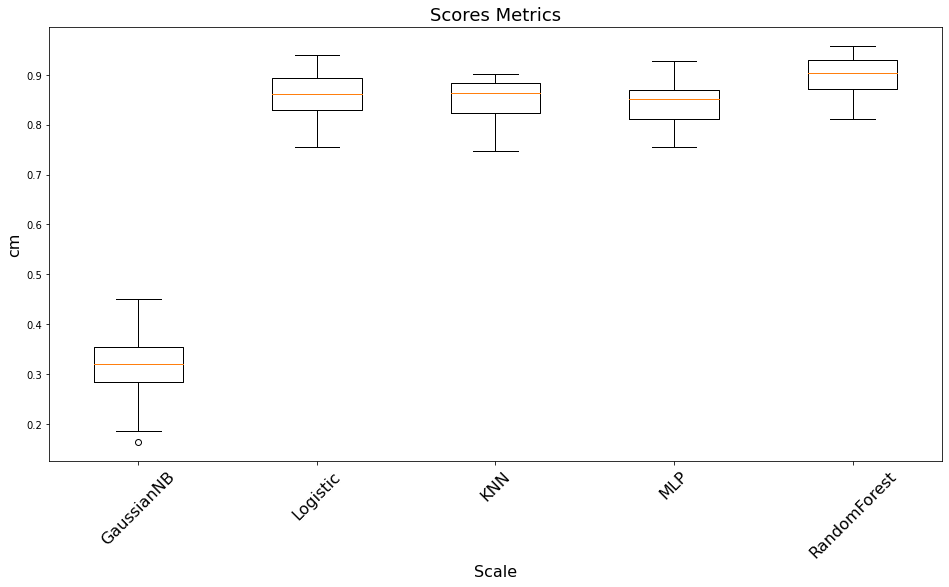

In [19]:
model_names = ['GaussianNB', 'Logistic', 'KNN', 'MLP', 'RandomForest']

# Draw bboxplot 
plt.figure(figsize=(16, 8))
plt.boxplot(all_scores)
plt.xlabel('Scale', fontsize=16)
plt.ylabel('cm', fontsize=16)
plt.xticks(np.arange(len(model_names))+1, model_names, rotation=45, fontsize=16)
plt.title("Scores Metrics", fontsize=18)

    Nhìn vào biểu đồ ta có thể thấy RandomForest là thuật toán có độ chính xác cao nhất khi score giao động trong khoảng từ 0.83 đến 0.95 
    và trung bình đạt được khoảng 0.9 nên chúng ta sẽ lựa chọn lớp mô hình này để phát triển thành production.

